In [1]:
import numpy as np
import pandas as pd
import json

### json

In [3]:
file_path = "/Users/olgaiarygina/Documents/GitHub/dc_keyboard/dc_keyboard/study_1/data_full.json"

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

In [4]:
# unpacking json
records = []
for identifier, value in data.items():
    trials = value["log"]["trials"]
    for trial in trials:
        record = {
            "identifier": identifier,
            "date": value["date"], 
            "condition": value["log"]["condition"],
            "trial": trial["trial"],
            "end_time": trial["end_time"],
            "start_time": trial["start_time"],
            "target": trial["target"],
            "entered": trial["entered"],
            "part": trial["part"],
            "block": trial["block"],
        }
        records.append(record)

# df from the list of dictionaries
df = pd.DataFrame(records)

In [5]:
# app-test filtering
df.groupby('identifier')['date'].agg(list)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['date'] >= '2023-08-10']

In [6]:
# filtering out empty trial (backend issue)
df = df.loc[df['trial'] != 32]

### metrics

In [42]:
len(df['identifier'].value_counts())

118

In [11]:
# calculate wpm per trial
# from pypl: The WPM is calculated by dividing characters per second by five and then multiplying that with 60.

def calculate_wpm(row):
    characters_typed = len(row['entered']) # num of characters typed
    time_taken_sec = row['end_time'] - row['start_time'] # time taken
    wpm = ((characters_typed / time_taken_sec) / 5) * 60 # wpm 
    return wpm

df['wpm'] = df.apply(calculate_wpm, axis = 1)

In [12]:
# character error rate (from jiwer)
import jiwer

def calculate_cer(row):
    cer = jiwer.cer(row['target'], row['entered'])
    return cer

df['cer'] = df.apply(calculate_cer, axis = 1)

In [13]:
df.head()

,identifier,date,condition,trial,end_time,start_time,target,entered,part,block,wpm,cer
1170,5705932755435520,2023-08-11 17:15:38,1,0,1691771923,1691771891,MY WATCH FELL IN THE WATER,MY WATCH FELL IN THE WATER,0,0,9.750000,0.0
1171,5705932755435520,2023-08-11 17:15:38,1,1,1691771951,1691771923,PREVAILING WIND FROM THE EAST,PREVAILING WIND FROM THE EAST,0,0,12.428571,0.0
1172,5705932755435520,2023-08-11 17:15:38,1,2,1691771985,1691771951,NEVER TOO RICH AND NEVER TOO THIN,NEVER TOO RICH AND NEVER TOO THIN,0,0,11.647059,0.0
1173,5705932755435520,2023-08-11 17:15:38,1,3,1691772005,1691771985,BREATHING IS DIFFICULT,BREATHING IS DIFFICULT,0,0,13.200000,0.0
1174,5705932755435520,2023-08-11 17:15:38,1,4,1691772029,1691772005,I CAN SEE THE RINGS ON SATURN,I CAN SEE THE RINGS ON SATURN,0,0,14.500000,0.0


### conditions

In [14]:
for index, row in df.iterrows():
    identifier = row['identifier']
    trial_num = row['trial']
    value = data.get(str(identifier), {})

    if value:
        trials = value["log"]["trials"]

        if trial_num < len(trials):
            trial = trials[trial_num]
            condition = value["log"]["condition"]
            part = trial["part"]
            keyboard = value["log"]["ux"][part]["keyboard"]

            # Assign the extracted "keyboard" value to the DataFrame
            df.at[index, 'keyboard'] = keyboard

In [15]:
print('cognitive wpm MEAN:', df[df["keyboard"] == "cognitive"]["wpm"].mean(), ' SD:', df[df["keyboard"] == "cognitive"]["wpm"].std(),
      '\nbaseline wpm MEAN:', df[df["keyboard"] == "baseline"]["wpm"].mean(), ' SD:', df[df["keyboard"] == "baseline"]["wpm"].std(),
      '\ncognitive cer MEAN:', df[df["keyboard"] == "cognitive"]["cer"].mean(), ' SD:', df[df["keyboard"] == "cognitive"]["cer"].std(),
      '\nbaseline cer MEAN:', df[df["keyboard"] == "baseline"]["cer"].mean(), ' SD:', df[df["keyboard"] == "baseline"]["wpm"].std())

cognitive wpm MEAN: 11.450954162599928  SD: 5.263012205026004 
baseline wpm MEAN: 10.817305726648692  SD: 3.554601027233318 
cognitive cer MEAN: 0.019865909125558325  SD: 0.10444197132931143 
baseline cer MEAN: 0.015333022381833365  SD: 3.554601027233318


In [11]:
# # condition 0 = cognitive first
# 
# # map "keyboard" values based on condition and trial number
# def map_keyboard(row):
#     condition = row['condition']
#     part_one = row['part'] == 0
# 
#     if (condition == 0 and part_one) or (condition == 1 and not part_one):
#         return "cognitive"
# 
#     return "baseline"
# 
# df['keyboard'] = df.apply(map_keyboard, axis=1)

### tests

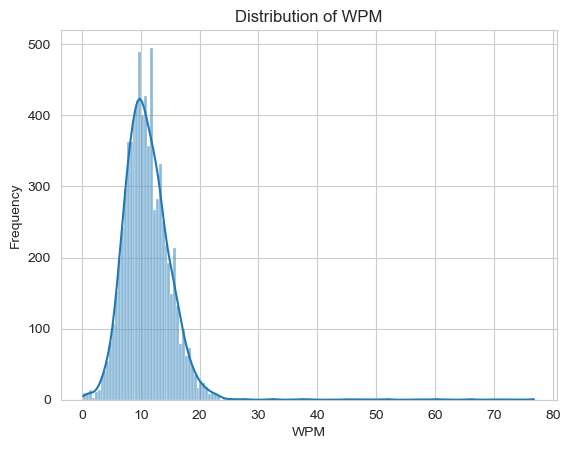

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df, x='wpm', kde=True)
plt.title('Distribution of WPM')
plt.xlabel('WPM')
plt.ylabel('Frequency')
plt.show()

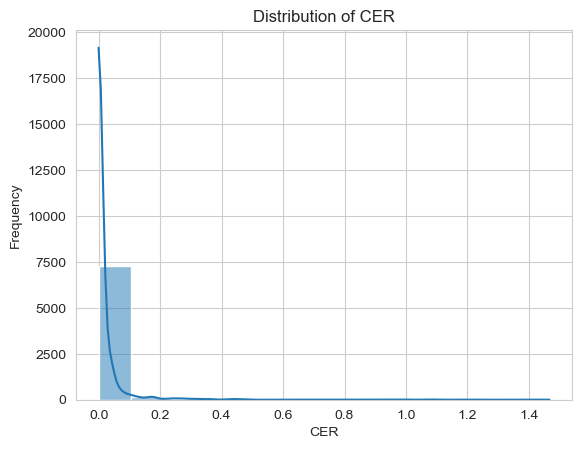

In [17]:
sns.histplot(data=df, x='cer', kde=True)
plt.title('Distribution of CER')
plt.xlabel('CER')
plt.ylabel('Frequency')
plt.show()

In [18]:
# # wpm
# 
# from scipy.stats import ttest_ind
# 
# cognitive_wpm = df.loc[df['keyboard'] == 'cognitive', 'wpm']
# baseline_wpm = df.loc[df['keyboard'] == 'baseline', 'wpm']
# 
# t_stat, p_value = ttest_ind(cognitive_wpm, baseline_wpm)
# 
# print("Two-Sample T-Test Results:")
# print("t-statistic:", t_stat)
# print("p-value:", p_value)
# 
# sns.histplot(data=df, x='wpm', hue='keyboard', kde=True)
# plt.title('Distribution of WPM for Cognitive and Baseline Keyboards')
# plt.xlabel('WPM')
# plt.ylabel('Frequency')
# plt.legend(title='Keyboard')
# plt.show()

In [19]:
# # cer
# 
# from scipy.stats import mannwhitneyu
# 
# cognitive_cer = df.loc[df['keyboard'] == 'cognitive', 'cer']
# baseline_cer = df.loc[df['keyboard'] == 'baseline', 'cer']
# 
# statistic, p_value = mannwhitneyu(cognitive_cer, baseline_cer)
# 
# print("Mann-Whitney U Test Results:")
# print("U-statistic:", statistic)
# print("p-value:", p_value)
# 
# sns.boxplot(data=df, x='keyboard', y='cer')
# plt.title('CER Comparison for Cognitive and Baseline Keyboards')
# plt.xlabel('Keyboard')
# plt.ylabel('Character Error Rate (CER)')
# plt.show()

### anova recalculation

##### wpm

In [20]:
df['block'].value_counts() # ???

0    944
1    944
2    944
3    944
5    944
6    944
7    944
4    826
8    118
Name: block, dtype: int64

In [21]:
df['block1'] = np.select(
    [
        (df['trial'] >= 0) & (df['trial'] <= 7) | (df['trial'] >= 33) & (df['trial'] <= 40),
        (df['trial'] >= 8) & (df['trial'] <= 15) | (df['trial'] >= 41) & (df['trial'] <= 48),
        (df['trial'] >= 16) & (df['trial'] <= 23) | (df['trial'] >= 49) & (df['trial'] <= 56),
        (df['trial'] >= 24) & (df['trial'] <= 31) | (df['trial'] >= 57) & (df['trial'] <= 64)
    ],
    [1, 2, 3, 4],
    default = None
)

In [22]:
import pingouin as pg

# repeated measures anova with interaction 
aov_interaction = pg.rm_anova(data=df, dv='wpm', within=['keyboard', 'block1'], subject = 'identifier')
print(aov_interaction)

# from statsmodels.stats.anova import AnovaRM
# aovrm = AnovaRM(df, 'wpm', 'identifier', within = ['keyboard', 'block1'], aggregate_func= 'mean')
# res = aovrm.fit()
# print(res)

              Source          SS  ddof1  ddof2         MS          F  \
0           keyboard   94.756440      1    117  94.756440   3.978046   
1             block1  250.515789      3    351  83.505263  47.117070   
2  keyboard * block1    6.597916      3    351   2.199305   1.206646   

          p-unc     p-GG-corr       ng2       eps  
0  4.842202e-02  4.842202e-02  0.007068  1.000000  
1  1.302238e-25  1.285586e-18  0.018470  0.696773  
2  3.072075e-01  3.007582e-01  0.000495  0.658635  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


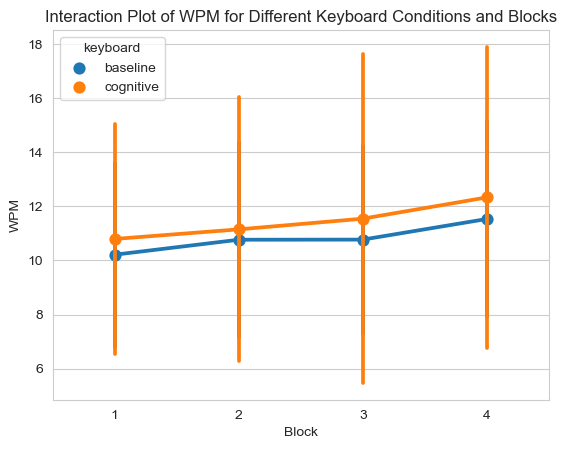

In [27]:
sns.pointplot(data = df, x = 'block1', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('Interaction Plot of WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()

/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


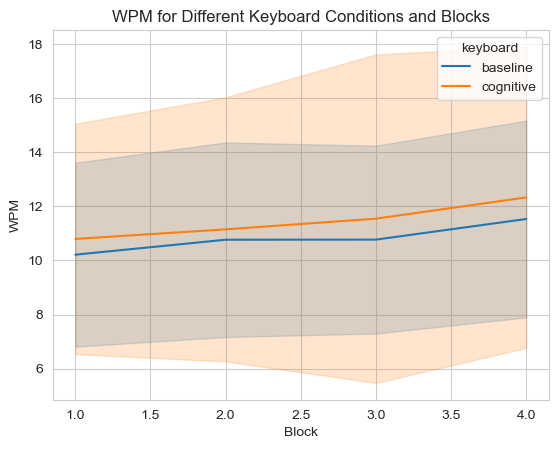

In [28]:
sns.lineplot(data = df, x = 'block1', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()

In [29]:
from statsmodels.stats.multicomp import MultiComparison

multi_comp = MultiComparison(df['wpm'], df['keyboard'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1    group2  meandiff p-adj lower upper  reject
-----------------------------------------------------
baseline cognitive   0.6336   0.0 0.431 0.8362   True
-----------------------------------------------------


In [30]:
multi_comp = MultiComparison(df['wpm'], df['block1'])
post_hoc_res = multi_comp.tukeyhsd()
print(post_hoc_res.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2   0.4532   0.01  0.0791 0.8273   True
     1      3   0.6524    0.0  0.2783 1.0265   True
     1      4   1.4255    0.0  1.0514 1.7996   True
     2      3   0.1993 0.5191 -0.1748 0.5734  False
     2      4   0.9724    0.0  0.5983 1.3464   True
     3      4   0.7731    0.0   0.399 1.1472   True
---------------------------------------------------


##### cer

In [31]:
cer_interaction = pg.rm_anova(data=df, dv='cer', within=['keyboard', 'block1'], subject = 'identifier')
print(cer_interaction)

              Source        SS  ddof1  ddof2        MS         F     p-unc  \
0           keyboard  0.004849      1    117  0.004849  0.435017  0.510834   
1             block1  0.002717      3    351  0.000906  1.786377  0.149412   
2  keyboard * block1  0.000623      3    351  0.000208  0.656169  0.579535   

   p-GG-corr       ng2       eps  
0   0.510834  0.000912  1.000000  
1   0.159472  0.000511  0.835790  
2   0.556518  0.000117  0.856197  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


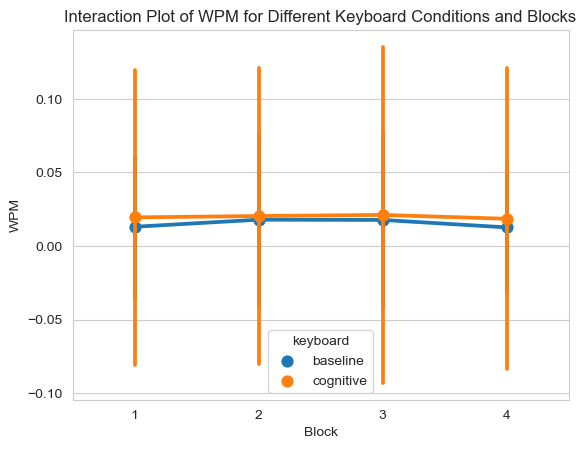

In [33]:
sns.pointplot(data = df, x = 'block1', y = 'cer', hue = 'keyboard', ci = 'sd')
plt.title('Interaction Plot of WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()

/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


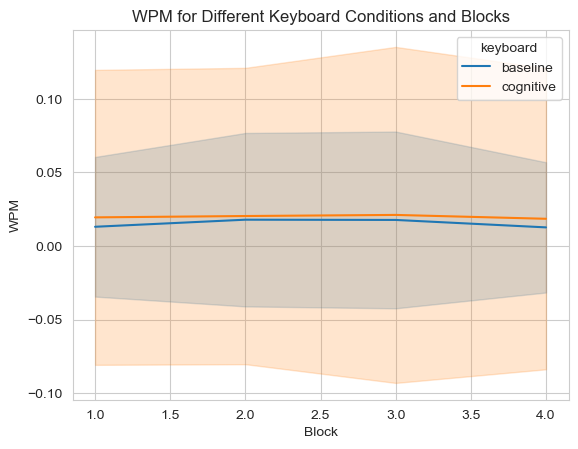

In [34]:
sns.lineplot(data = df, x = 'block1', y = 'cer', hue = 'keyboard', ci = 'sd')
plt.title('WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()

### outliers

In [36]:
print(df.head())

            identifier                date  condition  trial    end_time  \
1170  5705932755435520 2023-08-11 17:15:38          1      0  1691771923   
1171  5705932755435520 2023-08-11 17:15:38          1      1  1691771951   
1172  5705932755435520 2023-08-11 17:15:38          1      2  1691771985   
1173  5705932755435520 2023-08-11 17:15:38          1      3  1691772005   
1174  5705932755435520 2023-08-11 17:15:38          1      4  1691772029   

      start_time                             target  \
1170  1691771891         MY WATCH FELL IN THE WATER   
1171  1691771923      PREVAILING WIND FROM THE EAST   
1172  1691771951  NEVER TOO RICH AND NEVER TOO THIN   
1173  1691771985             BREATHING IS DIFFICULT   
1174  1691772005      I CAN SEE THE RINGS ON SATURN   

                                entered  part  block        wpm  cer  \
1170         MY WATCH FELL IN THE WATER     0      0   9.750000  0.0   
1171      PREVAILING WIND FROM THE EAST     0      0  12.428571  0.0

In [37]:
df['cer'].describe()

count    7552.000000
mean        0.017599
std         0.082891
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.466667
Name: cer, dtype: float64

In [38]:
df['wpm'].describe()

count    7552.000000
mean       11.134130
std         4.501662
min         0.201382
25%         8.470588
50%        10.702703
75%        13.333333
max        76.800000
Name: wpm, dtype: float64

In [59]:
df.nlargest(10, 'wpm')

,identifier,date,condition,trial,end_time,start_time,target,entered,part,block,wpm,cer,keyboard,block1
4476,5689069036109824,2023-08-11 18:03:38,1,56,1691776885,1691776880,LOVE MEANS MANY THINGS,SSLNSOSFMFM MQYQYQQY QSQYQYQ FSQ,1,7,76.800000,1.181818,cognitive,3
4483,5689069036109824,2023-08-11 18:03:38,1,63,1691776966,1691776961,BEWARE THE IDES OF MARCH,DSQHY DFGDYYG DGGQGQY QHFMQ QHFH,1,7,76.800000,1.166667,cognitive,4
4472,5689069036109824,2023-08-11 18:03:38,1,52,1691776861,1691776855,WE RUN THE RISK OF FAILURE,IPILJLJ HLJLBL WLILJL BLJLJY HAIDI GL,1,6,74.000000,1.153846,cognitive,3
4475,5689069036109824,2023-08-11 18:03:38,1,55,1691776880,1691776874,GREAT DISTURBANCE IN THE FORCE,NSGLNFNY NSSNQFS NQSNDD LDNNLLL NNNS,1,6,72.000000,1.000000,cognitive,3
4474,5689069036109824,2023-08-11 18:03:38,1,54,1691776874,1691776867,HE IS JUST LIKE EVERYONE ELSE,LHLHDH HLSDBLB ILHCGCH JLHLHLH GCGAKHN GC,1,6,70.285714,1.206897,cognitive,3
4471,5689069036109824,2023-08-11 18:03:38,1,51,1691776855,1691776846,PLEASE PROVIDE YOUR DATE OF BIRTH,SQMYLDYDYDYDY ELDJLIKLHLGL LHDGLJL JLJLH LJLJK...,1,6,69.333333,1.363636,cognitive,3
4468,5689069036109824,2023-08-11 18:03:38,1,48,1691776776,1691776772,CIRCUMSTANCES ARE UNACCEPTABLE,LWLWLILI ILBPJK WLHLJ,1,6,66.000000,0.933333,cognitive,2
4484,5689069036109824,2023-08-11 18:03:38,1,64,1691776972,1691776966,DOUBLE DOUBLE TOIL AND TROUBLE,SHQGQYF SQGQMD DGFMLL DFOFM DSFOL,1,8,66.000000,0.966667,cognitive,4
4479,5689069036109824,2023-08-11 18:03:38,1,59,1691776937,1691776930,CAN I SKATE WITH SISTER TODAY,SGSSSSS F N N QFFF FFWNDQ NGHLQJWM,1,7,61.714286,1.068966,cognitive,4
4473,5689069036109824,2023-08-11 18:03:38,1,53,1691776867,1691776861,PRAYER IN SCHOOLS OFFENDS SOME,KIQLILI HLJLNJ HLHDQJ HLGDDG G,1,6,60.000000,0.933333,cognitive,3


In [60]:
filtered_df = df[df['identifier'] != "5689069036109824"]

In [61]:
len(filtered_df['identifier'].value_counts())

117

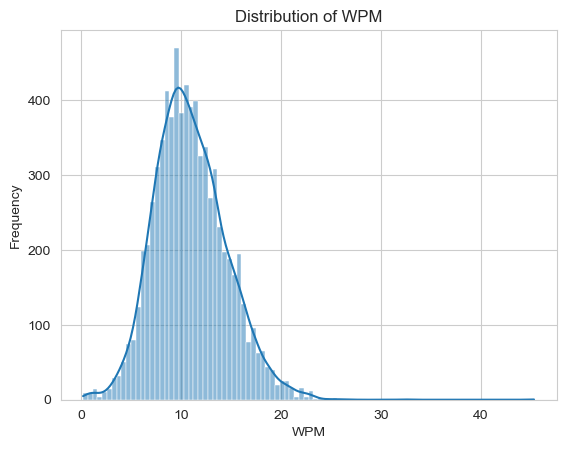

In [62]:
sns.histplot(data=filtered_df, x='wpm', kde=True)
plt.title('Distribution of WPM')
plt.xlabel('WPM')
plt.ylabel('Frequency')
plt.show()

In [63]:
filtered_wpm_interaction = pg.rm_anova(data=filtered_df, dv='wpm', within=['keyboard', 'block1'], subject = 'identifier')
print(filtered_wpm_interaction)

              Source          SS  ddof1  ddof2         MS          F  \
0           keyboard   27.455247      1    116  27.455247   7.126696   
1             block1  217.825805      3    348  72.608602  70.793763   
2  keyboard * block1    4.027964      3    348   1.342655   1.324024   

          p-unc     p-GG-corr       ng2       eps  
0  8.683712e-03  8.683712e-03  0.003693  1.000000  
1  9.196806e-36  2.292130e-34  0.028566  0.957776  
2  2.663386e-01  2.670227e-01  0.000543  0.949948  


/Users/olgaiarygina/opt/anaconda3/envs/PycharmProjects/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  """Entry point for launching an IPython kernel.


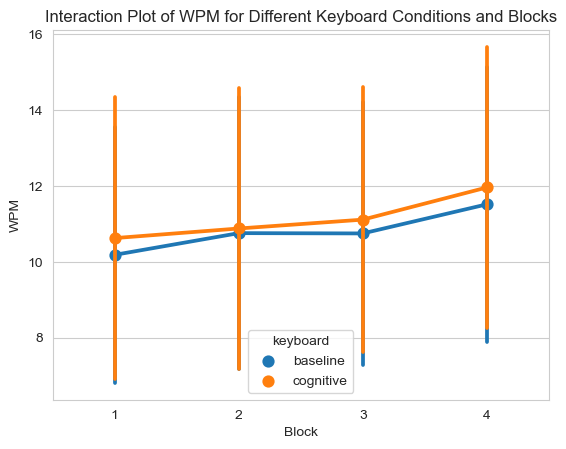

In [64]:
sns.pointplot(data = filtered_df, x = 'block1', y = 'wpm', hue = 'keyboard', ci = 'sd')
plt.title('Interaction Plot of WPM for Different Keyboard Conditions and Blocks')
plt.xlabel('Block')
plt.ylabel('WPM')
plt.show()